# Layer activation normalization (Batch normalization)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/4.batch-normalization.ipynb)

By [Terence Parr](https://explained.ai).

*In progress...can't get a good example that uses a toy data set* (I also decided this is not the right time to introduce the complexity of batch normalization.)

Just as we normalize or standardize the input variables, networks train better if we normalize the output of each layer's activation. It is called batch normalization because we normally train with batches of records not the entire data set, but it's really just allowing the model to shift and scale each neurons activation. Batch normalization does not use the joint distribution. Each neuron activation is "whitened" independently by subtracting the mean and dividing by the standard deviation. Then, we scale and shift that data using two new model parameters to support layer activation distributions that are useful for training purposes.

At test time, we use mean/var estimated during training for activations to whiten the activations as the test instance sails through the network. The learned parameters scale and shift the layer activations but do not change the shape of the distribution. This technique helps move gradients through the network during training without exploding or vanishing.

As with normalizing the input layer, batch normalization is believed to support faster learning rates for faster training. It also has a mild regularization effect per Andrew Ng, improving model generality. The model could also be less sensitive to the initialization procedure.  See [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167) for more information and video [Why Does Batch Norm Work?](https://www.youtube.com/watch?v=nUUqwaxLnWs).

## Support code

In [1]:
import os
import sys
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

In [2]:
def plot_history(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")

In [3]:
def train(model, X_train, X_test, y_train, y_test,
          learning_rate = .5, nepochs=2000, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"BEST MSE test loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

In [4]:
d = load_diabetes()
len(d.data)

442

In [5]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [6]:
np.random.seed(1) # set a random seed for consistency across runs
n = len(df)
n_test = int(n*0.20) # 20% held out as validation set
n_train = n - n_test
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [7]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

As we did in the previous notebook, let's get a baseline (although it's the same as before).

In [8]:
rf = RandomForestRegressor(n_estimators=500)#, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 455.43 validation MSE 3405.60


## No batch normalization

We know how to train a vanilla neural network on this data, so let's do that again to reinforce our understanding and get the results into this notebook as well for comparison purposes. (We'll see how batch normalization performs after this.) Let's start by converting the numpy arrays into pytorch tensors:

In [9]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

Epoch    0 MSE train loss    29824.736   test loss    25906.725
Epoch  100 MSE train loss     2498.819   test loss     3001.228
Epoch  200 MSE train loss     2362.622   test loss     2951.789
Epoch  300 MSE train loss     2170.585   test loss     3284.207
Epoch  400 MSE train loss     2080.921   test loss     3272.910
Epoch  500 MSE train loss     1989.582   test loss     3354.512
Epoch  600 MSE train loss     1976.366   test loss     3439.697
Epoch  700 MSE train loss     1960.431   test loss     3484.861
Epoch  800 MSE train loss     1954.916   test loss     3476.629
Epoch  900 MSE train loss     1933.969   test loss     3574.152
Epoch 1000 MSE train loss     1970.010   test loss     3607.064
BEST MSE test loss 2925.281 at epoch 182


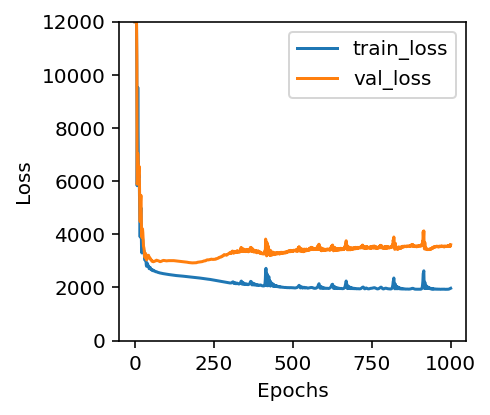

In [79]:
ncols = X.shape[1]
n_neurons = 10
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train(model, X_train, X_test, y_train, y_test,
                            learning_rate=.3, nepochs=1000,
                            weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)

plot_history(torch.clamp(history, 0, 12000))

## Batch normalization prior to nonlinearity


Epoch    0 MSE train loss    29855.828   test loss    25954.975
Epoch  100 MSE train loss     2341.888   test loss     3284.765
Epoch  200 MSE train loss     2190.471   test loss     3271.307
Epoch  300 MSE train loss     2124.554   test loss     3266.053
Epoch  400 MSE train loss     2086.827   test loss     3269.585
Epoch  500 MSE train loss     2059.068   test loss     3292.539
Epoch  600 MSE train loss     2033.019   test loss     3312.165
Epoch  700 MSE train loss     2008.856   test loss     3340.174
Epoch  800 MSE train loss     1984.274   test loss     3380.038
Epoch  900 MSE train loss     1960.679   test loss     3420.923
Epoch 1000 MSE train loss     1939.954   test loss     3465.430
BEST MSE test loss 3126.286 at epoch 58


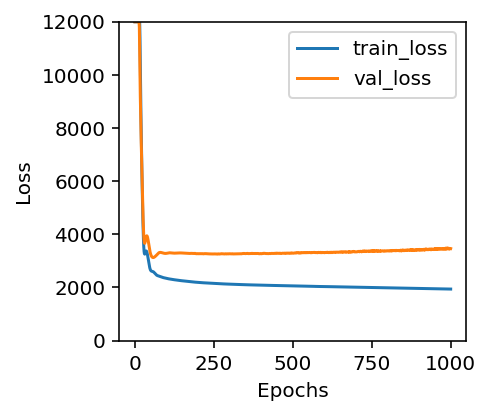

In [89]:
ncols = X.shape[1]
n_neurons = 300
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.BatchNorm1d(n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train(model, X_train, X_test, y_train, y_test,
                            learning_rate=.02, nepochs=1000,
                            weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)

plot_history(torch.clamp(history, 0, 12000))

## Batch normalization after nonlinearity

Epoch    0 MSE train loss    29825.834   test loss    25912.461
Epoch  100 MSE train loss     1580.148   test loss     4041.223
Epoch  200 MSE train loss      599.812   test loss     5057.402
Epoch  300 MSE train loss      192.489   test loss     5665.648
Epoch  400 MSE train loss       83.200   test loss     6629.621
Epoch  500 MSE train loss       32.758   test loss     7357.072
Epoch  600 MSE train loss       26.932   test loss     7657.275
Epoch  700 MSE train loss       20.176   test loss     7938.530
Epoch  800 MSE train loss       16.955   test loss     8132.025
Epoch  900 MSE train loss       12.196   test loss     8320.524
Epoch 1000 MSE train loss        8.558   test loss     8386.548
BEST MSE test loss 3331.539 at epoch 35


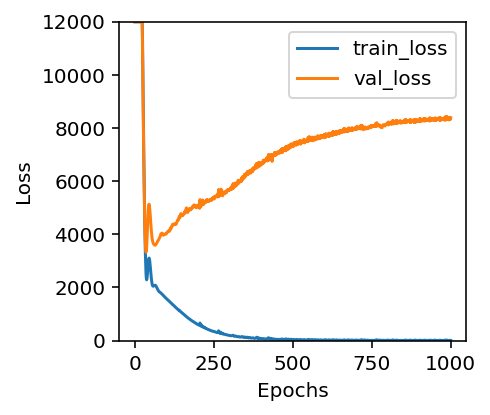

In [87]:
ncols = X.shape[1]
n_neurons = 300
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.BatchNorm1d(n_neurons),
#     nn.Linear(n_neurons, n_neurons),
#     nn.ReLU(),
#     nn.BatchNorm1d(n_neurons),
    nn.Linear(n_neurons, 1)
)

history, best_model = train(model, X_train, X_test, y_train, y_test,
                            learning_rate=.02, nepochs=1000,
                            weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)

plot_history(torch.clamp(history, 0, 12000))

At least for this data set and a random train/test set, batch normalization gives us much faster convergence to the best validation loss and also we get a lower test loss:

1. No normalization: BEST MSE test loss 3073.239 at epoch 47
1. Prior to ReLU: BEST MSE test loss 2997.867 at epoch 30
1. Post ReLU: BEST MSE test loss 3073.734 at epoch 19

In the end, this data set is pretty small and perhaps not the most impressive demonstration of batch normalization, but it serves our purposes to demonstrate the technique.

See [Batch Normalization before or after ReLU?](https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/).